# Task 2: DG With IRM Variants

Consider the following IRM based methods, as studied in the class:


**IRM-Basic:**

The objective of basic IRM is to minimize the following loss:

$$
 min_{Φ: Χ →𝑌} \sum_{e \in E_{\text{train}}} R^e(\Phi) + \lambda \cdot \left\| \nabla_\omega \Big|_{\omega=1.0} R_e(\omega \cdot \Phi) \right\|^2
$$

where
* $\Phi$ is the feature extractor
* $R^e(\Phi)$ is the empirical risk for environment $e$
* $E_{\text{train}}$ is the set of training environments
* $ω$ is a classifier head controlling representation
* $λ$ is the regularization strength of the invariance penalty


For implementation, you will have to compute the standard cross-entropy loss: $R^c(\Phi)=𝔼_{\text{(x,y)~e}}[-y⋅log(\Phi(x))]$
along with Invariance Penalty $\left\| \nabla_\omega \Big|_{\omega=1.0} R_e(\omega \cdot \Phi) \right\|^2$ and then combine will give you total loss: Loss = $\sum_{e \in E_{\text{train}}} R^c(\Phi)+\lambda⋅Penalty$  
  
    


<br>**IB-IRM:**  
IB-IRM improves upon IRM Basic by adding a regularization term that penalizes the variance of the feature extractor $\Phi$. The objective is:

$$
min_{Φ: Χ →𝑌} \sum_{e \in E_{\text{train}}} R_e(\Phi) + \lambda \cdot \left\| \nabla_\omega \Big|_{\omega=1.0} R_e(\omega \cdot \Phi) \right\|^2 + \gamma \cdot \text{Var}(\Phi)
$$

Where $Var(\Phi)$ is the variance of feature representations across samples. For variance computation, you can use:

$$
\text{Var}(\Phi) = \frac{1}{N} \sum_{i=1}^N \|\Phi(x_i) - \mu\|^2, \quad \mu = \frac{1}{N} \sum_{i=1}^N \Phi(x_i)
$$

<br>**PAIR: Pareto IRM:**  
PAIR introduces a Pareto optimization approach to balance multiple objectives:
ERM, IRM Basic penalty, and variance regularization. The objective is:

$$
min_{Φ: Χ →𝑌} \,\,\,\,\,L_{\text{ERM}},L_{\text{IRMv1}},L_{\text{Var}}
$$

Where:

* $L_{\text{ERM}} = \sum_{e \in E_{\text{train}}} R_e(\Phi)$
*$L_{\text{IRMv1}} = \lambda \cdot \left\| \nabla_\omega \Big|_{\omega=1.0} R_e(\omega \cdot \Phi) \right\|^2$
*$L_{\text{Var}} = \gamma \cdot \text{Var}(\Phi)$


Pareto optimization balances these three losses rather than combining them into a single scalar objective. For
implementation, you can treat each loss as a separate objective and then use multi-objective optimization
techniques to minimize all objectives simultaneously. One common approach is Weighted Sum Optimization:

$$
Loss= L_{\text{ERM}} + w_2 L_{\text{IRMv1}} + w_3 L_{\text{Var}}
$$

where $w_1$,$w_2$,$w_3$ are weights chosen to balance the trade-offs. Alternatively, you can implement a Pareto
Front search using gradient-based optimization (read about it on your own).
1. Implement these three methods of IRM i.e. IRM Basic, IB-IRM, and PAIR. Train models on the source
domains and evaluate on the target domain (OOD setup). Measure and report OOD accuracy for all
methods. Which method achieves the highest OOD accuracy? How does regularization in IB-IRM and PAIR affect this trade-offcompared to IRM Basic?
2. Explore whether there is any trade-off between IID and OOD accuracy in these approximation methods
of IRM. You can track IID and OOD accuracy over training steps, and see how do your models perform.
For each method, you can then plot the OOD accuracy (y-axis) against IID accuracy (x-axis) during
training steps. Analyze the trends for each method like does improving IID accuracy degrade OOD
accuracy? Which method achieves the best balance between ID and OOD accuracy?

Imports

In [35]:
import os
import torch
from torch.utils.data import Dataset,random_split
from PIL import Image
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
# from google.colab import drive
# drive.mount('/content/drive')
# from torch.cuda.amp import autocast, GradScaler
from torch.amp import autocast
from torch import GradScaler
import time
import numpy as np
from torchvision.datasets import MNIST

Dataset Preparation

In [36]:
class RotateExact:
    def __init__(self, angle):
        self.angle = angle

    def __call__(self, img):
        return transforms.functional.rotate(img, self.angle)

def get_data_loaders_rmnist(batch_size=32):

    train_loaders=[]
    test_loaders=[]
    domain_names=[]

    for i in range(4):
      # Define image transformations
      if i==0:
        transform = transforms.Compose([
            # transforms.Resize((224, 224)),
            RotateExact(angle=0),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5], std=[0.5]),
        ])
        domain_names.append(str(0))
      else:
        transform = transforms.Compose([
            # transforms.Resize((224, 224)),
            RotateExact(angle=30+15*i),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5], std=[0.5]),
        ])
        domain_names.append(str(30+15*i))

      # Load RMNIST dataset
      train_dataset_i = MNIST(root='./data', train=True, download=True, transform=transform)
      test_dataset_i = MNIST(root='./data', train=False, download=True, transform=transform)

      # Create data loaders
      train_loader_i = DataLoader(train_dataset_i, batch_size=batch_size, shuffle=True, num_workers=2)
      test_loader_i = DataLoader(test_dataset_i, batch_size=batch_size, shuffle=False, num_workers=2)

      train_loaders.append(train_loader_i)
      test_loaders.append(test_loader_i)


    return train_loaders, test_loaders, domain_names, 10


def visualize_batch(data_loader, num_images=16):
    # Get a batch of images and labels
    images, labels = next(iter(data_loader))

    # Make a grid from the batch
    grid = torchvision.utils.make_grid(images[:num_images], nrow=4, normalize=True)

    # Convert the tensor to a numpy array and transpose it for display
    grid = grid.numpy().transpose((1, 2, 0))

    # Display the grid of images
    plt.figure(figsize=(10, 10))
    plt.imshow(grid)
    plt.title("Labels: " + ", ".join(map(str, labels[:num_images].tolist())))
    plt.axis("off")
    plt.show()


print("sanity check")

sanity check


Visualizing a batch from 0 degree domain


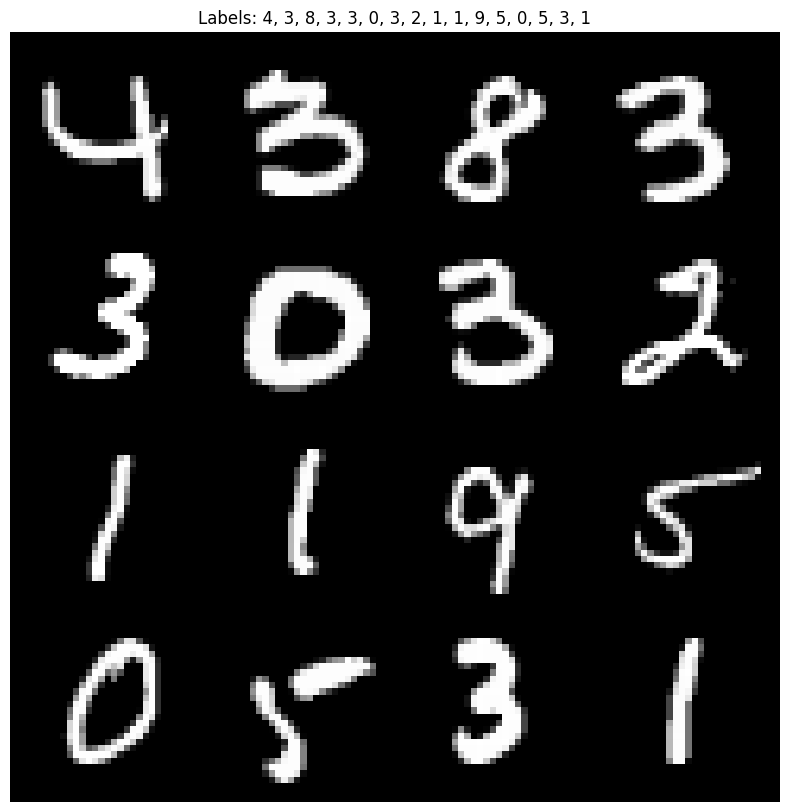

Visualizing a batch from 45 degree domain


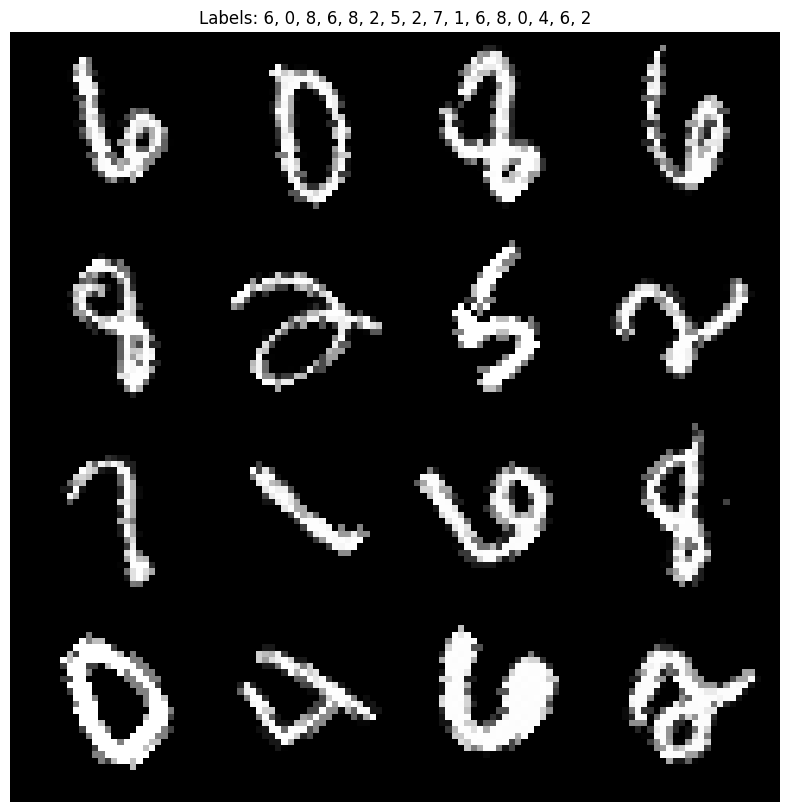

Visualizing a batch from 60 degree domain


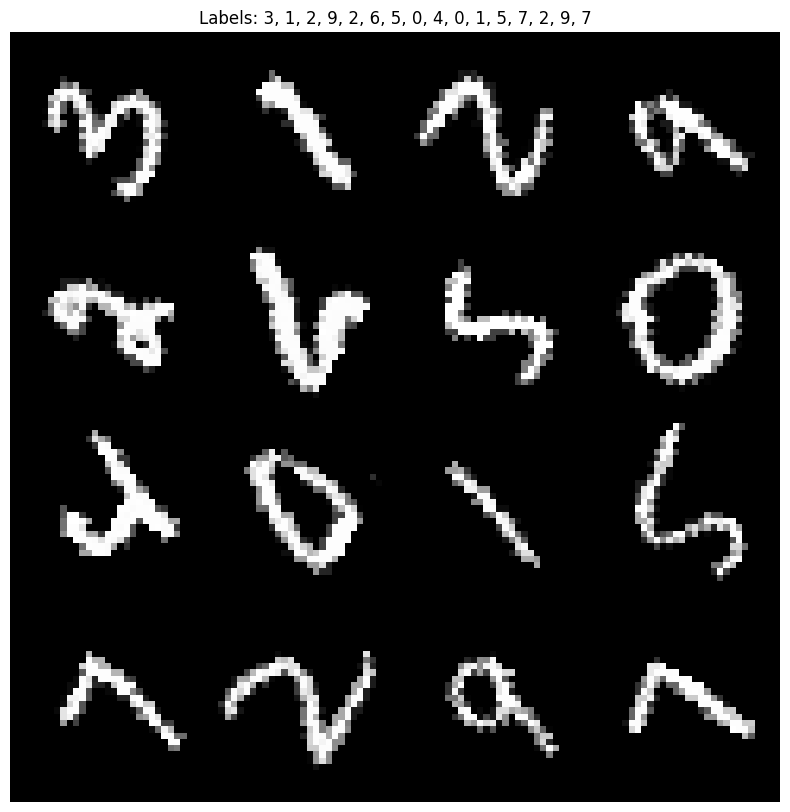

Visualizing a batch from 75 degree domain


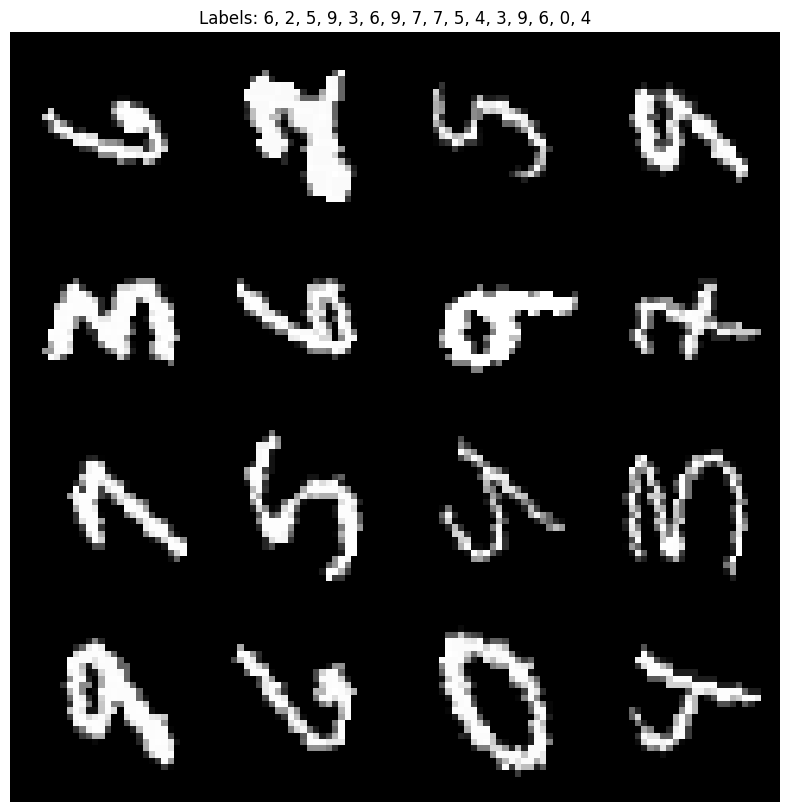

In [37]:
train_loaders, test_loaders, domain_names, num_classes = get_data_loaders_rmnist(batch_size=64)

for i in range(len(train_loaders)):
  print(f"Visualizing a batch from {domain_names[i]} degree domain" )
  visualize_batch(train_loaders[i])

In [38]:
# class PACS(Dataset):
#     def __init__(self, root_dir, domain, transform=None):
#         self.root_dir = root_dir
#         self.domain = domain
#         self.transform = transform
#         self.categories = sorted(os.listdir(os.path.join(root_dir, domain)))
#         self.images = []
#         self.labels = []

#         for category in self.categories:
#             category_dir = os.path.join(root_dir, domain, category)
#             for image_file in os.listdir(category_dir):
#                 image_path = os.path.join(category_dir, image_file)
#                 self.images.append(image_path)
#                 self.labels.append(self.categories.index(category))

#     def __len__(self):
#         return len(self.images)

#     def __getitem__(self, index):
#         image_path = self.images[index]
#         label = self.labels[index]
#         image = Image.open(image_path)
#         if self.transform:
#             image = self.transform(image)
#         return image, label


# def get_data_loaders_pacs(batch_size=32,split_ratio=0.8):
#     # Define image transformations
#     transform = transforms.Compose([
#         transforms.Resize((224, 224)),
#         transforms.ToTensor(),
#         transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
#     ])

#     # Load PACS dataset

#     dataset_photo = PACS(root_dir='/content/drive/MyDrive/Advanced_ML/PA1/PA1_Datasets/pacs_data/pacs_data', domain='photo',transform=transform)
#     train_size = int(len(dataset_photo) * split_ratio)
#     test_size = len(dataset_photo) - train_size
#     train_dataset_photo, test_dataset_photo = random_split(dataset_photo, [train_size, test_size])

#     dataset_art = PACS(root_dir='/content/drive/MyDrive/Advanced_ML/PA1/PA1_Datasets/pacs_data/pacs_data', domain='art_painting', transform=transform)
#     train_size = int(len(dataset_art) * split_ratio)
#     test_size = len(dataset_art) - train_size
#     train_dataset_art, test_dataset_art = random_split(dataset_art, [train_size, test_size])

#     dataset_cartoon= PACS(root_dir='/content/drive/MyDrive/Advanced_ML/PA1/PA1_Datasets/pacs_data/pacs_data', domain='cartoon', transform=transform)
#     train_size = int(len(dataset_cartoon) * split_ratio)
#     test_size = len(dataset_cartoon) - train_size
#     train_dataset_cartoon, test_dataset_cartoon = random_split(dataset_cartoon, [train_size, test_size])

#     dataset_sketches=PACS(root_dir='/content/drive/MyDrive/Advanced_ML/PA1/PA1_Datasets/pacs_data/pacs_data', domain='sketch', transform=transform)
#     train_size = int(len(dataset_sketches) * split_ratio)
#     test_size = len(dataset_sketches) - train_size
#     train_dataset_sketches, test_dataset_sketches = random_split(dataset_sketches, [train_size, test_size])


#     # Create data loaders
#     train_loader_photo = DataLoader(train_dataset_photo, batch_size=batch_size, shuffle=True, num_workers=4)
#     test_loader_photo = DataLoader(test_dataset_photo, batch_size=batch_size, shuffle=False, num_workers=4)

#     train_loader_art = DataLoader(train_dataset_art, batch_size=batch_size, shuffle=True, num_workers=4)
#     test_loader_art = DataLoader(test_dataset_art, batch_size=batch_size, shuffle=False, num_workers=4)

#     train_loader_cartoon = DataLoader(train_dataset_cartoon, batch_size=batch_size, shuffle=True, num_workers=4)
#     test_loader_cartoon = DataLoader(test_dataset_cartoon, batch_size=batch_size, shuffle=False, num_workers=4)

#     train_loader_sketches = DataLoader(train_dataset_sketches, batch_size=batch_size, shuffle=True, num_workers=4)
#     test_loader_sketches = DataLoader(test_dataset_sketches, batch_size=batch_size, shuffle=False, num_workers=4)

#     return train_loader_photo, test_loader_photo, train_loader_art, test_loader_art,train_loader_cartoon, test_loader_cartoon,train_loader_sketches, test_loader_sketches, 7


# def visualize_batch(data_loader, num_images=16):
#     # Get a batch of images and labels
#     images, labels = next(iter(data_loader))

#     # Make a grid from the batch
#     grid = torchvision.utils.make_grid(images[:num_images], nrow=4, normalize=True)

#     # Convert the tensor to a numpy array and transpose it for display
#     grid = grid.numpy().transpose((1, 2, 0))

#     # Display the grid of images
#     plt.figure(figsize=(10, 10))
#     plt.imshow(grid)
#     plt.title("Labels: " + ", ".join(map(str, labels[:num_images].tolist())))
#     plt.axis("off")
#     plt.show()


# print("sanity check")

In [39]:
# train_loader_photo, test_loader_photo, train_loader_art, test_loader_art,train_loader_cartoon, test_loader_cartoon,train_loader_sketches, test_loader_sketches, num_classes=get_data_loaders_pacs()


# # Visualize a batch from each data loader
# print("Visualizing a batch from Photo domain:")
# visualize_batch(train_loader_photo)

# print("Visualizing a batch from Art Painting domain:")
# visualize_batch(train_loader_art)

# print("Visualizing a batch from Cartoon domain:")
# visualize_batch(train_loader_cartoon)

# print("Visualizing a batch from Sketch domain:")
# visualize_batch(train_loader_sketches)

Defining Feature Extractor and Classifier

In [40]:
# Feature extractor
class FeatureExtractor(nn.Module):
    def __init__(self):
        super(FeatureExtractor, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        #self.conv1 = nn.Conv2d(3, 32, kernel_size=3)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        # Dummy pass to calculate the size of the flattened feature map
        self._to_linear = None
        self._calculate_linear_size()

        # Now we can use this calculated size for the fully connected layer
        self.fc1 = nn.Linear(self._to_linear, 128)

    def _calculate_linear_size(self):
        # Pass a dummy input through the conv layers to calculate the flattened size
        dummy_input = torch.zeros(1, 1, 28, 28)
        x = F.relu(self.conv1(dummy_input))
        x = F.relu(self.conv2(x))
        self._to_linear = x.numel()

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        return x

# Classifier
class Classifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(Classifier, self).__init__()
        self.fc = nn.Linear(input_dim, num_classes)

    def forward(self, x):
        return self.fc(x)

Defining Penalty and Training functions

In [41]:
def irm_penalty(loss, feature_extractor, classifier, device):
    scale = torch.tensor(1.0, device=device, requires_grad=True)  # Ensure scale is on the same device
    scaled_loss = loss * scale  # Incorporate scale into the computation graph
    grad = torch.autograd.grad(scaled_loss, [scale], create_graph=True)[0]
    return torch.sum(grad**2)
    #scale = torch.tensor(1.).cuda().requires_grad_()
    # grad = torch.autograd.grad(loss, [scale], create_graph=True)[0]
    # return torch.sum(grad**2)
    # grads = torch.autograd.grad(loss, classifier.parameters(), create_graph=True, retain_graph=True)
    # penalty = sum((grad ** 2).sum() for grad in grads)
    # return penalty

def compute_variance(features):
    mean_feature = features.mean(dim=0, keepdim=True)
    variance = ((features - mean_feature) ** 2).mean()
    return variance


def training_irm(classifier, feature_extractor, source_loaders,source_loader_names,source_testers,test_loaders,test_loader_names, optimizer, device, num_epochs,lambda_penalty,gamma_var, w1,w2,w3,technique):
  # Training
  scaler = GradScaler()
  iid_accs=np.zeros((len(source_loaders),num_epochs))
  ood_accs=np.zeros((len(test_loaders),num_epochs))



  for epoch in range(num_epochs):
      running_loss = 0.0
      correct = 0
      total = 0
      start_time = time.time()
      i=0
      for loaders in source_loaders:
          print("Source Dataset ", source_loader_names[i])
          for batch_idx, (inputs, labels) in enumerate(loaders):
              inputs, labels = inputs.to(device), labels.to(device)


              # Forward pass
              optimizer.zero_grad()
              with autocast(device_type=device.type):
                features = feature_extractor(inputs)
                predictions = classifier(features)
                loss = nn.CrossEntropyLoss()(predictions, labels)

                if technique=='basic':
                  # Compute IRM penalty
                  penalty = irm_penalty(loss, feature_extractor, classifier, device)
                  loss = loss + lambda_penalty * penalty

                elif technique=='ib':
                  # Compute IRM penalty
                  penalty = irm_penalty(loss, feature_extractor, classifier, device)
                  #Compute Variance
                  variance=compute_variance(features)
                  loss = loss + lambda_penalty * penalty + gamma_var*variance

                elif technique=='pair':
                  # Compute IRM penalty
                  penalty = irm_penalty(loss, feature_extractor, classifier, device)
                  #Compute Variance
                  variance=compute_variance(features)
                  loss = w1*loss + w2*lambda_penalty*penalty + w3*gamma_var*variance




              # Backpropagation

              scaler.scale(loss).backward()
              scaler.step(optimizer)
              scaler.update()

              running_loss += loss.item()

              _, predicted = torch.max(predictions.data, 1)
              total += labels.size(0)
              correct += (predicted == labels).sum().item()

              if (batch_idx + 1) % 20 == 0:
                print(f"Epoch [{epoch + 1}/{num_epochs}], Batch [{batch_idx + 1}/{len(loaders)}], Loss: {loss.item():.4f}")

          epoch_loss = running_loss / len(loaders)
          epoch_accuracy = 100 * correct / total
          print(f"Epoch [{epoch + 1}/{num_epochs}] completed in {time.time() - start_time:.2f} seconds. "
                f"Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%")
          i=i+1
      j=0
      print("IID Accuracies")
      for loaders in source_testers:
        accuracy=evaluate(loaders,feature_extractor,classifier)
        iid_accs[j,epoch]=accuracy
        print(f"Accuracy-IID Dataset {source_loader_names[j]}: {accuracy * 100:.2f}%")
        j=j+1
      k=0
      print("OOD Accuracies")
      for loaders in test_loaders:
        accuracy=evaluate(loaders,feature_extractor,classifier)
        ood_accs[k,epoch]=accuracy
        print(f"Accuracy-OOD Dataset {test_loader_names[k]}: {accuracy * 100:.2f}%")
        k=k+1
  return iid_accs,ood_accs



Evaluation Function

In [42]:
def evaluate(loader, feature_extractor, classifier):
    feature_extractor.eval()
    classifier.eval()
    correct = 0
    with torch.no_grad():
        for data, target in loader:
            data, target = data.to(device), target.to(device)
            features = feature_extractor(data)
            predictions = classifier(features)
            correct += (predictions.argmax(1) == target).sum().item()
    return correct / len(loader.dataset)

Setup


In [43]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
lambda_penalty=0.5
gamma_var=0.5
w1=1.5
w2=1
w3=1.5
num_epochs=5

source_loaders=[]
source_loaders_names=[]
source_testers=[]
for i in range(3):
  # print(i+1)
  source_loaders.append(train_loaders[i+1])
  source_loaders_names.append(domain_names[i+1])
  source_testers.append(test_loaders[i+1])

test_loaders=[test_loaders[0]]
test_loader_names=[domain_names[0]]

In [44]:
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# lambda_penalty=1
# gamma_var=1
# w1=0.5
# w2=0.3
# w3=0.2
# num_epochs=5

# source_loaders=[train_loader_photo,train_loader_cartoon,train_loader_sketches]
# source_testers=[test_loader_photo,test_loader_cartoon,test_loader_sketches]
# source_loaders_names=['photo','cartoon','sketch']
# test_loaders=[test_loader_art]
# test_loader_names=['art']

IRM-Basic

In [45]:
feature_extractor_basic = FeatureExtractor().to(device)
classifier_basic = Classifier(128,num_classes).to(device)
optimizer_basic = optim.Adam(list(feature_extractor_basic.parameters()) + list(classifier_basic.parameters()), lr=1e-3)
iid_acc_basic,ood_acc_basic=training_irm(classifier=classifier_basic, feature_extractor=feature_extractor_basic, source_loaders=source_loaders, source_loader_names=source_loaders_names,source_testers=source_testers,test_loaders=test_loaders,test_loader_names=test_loader_names, optimizer=optimizer_basic, device=device, num_epochs=5,lambda_penalty=lambda_penalty,gamma_var=gamma_var, w1=w1,w2=w2,w3=w3,technique='basic')

Source Dataset  45
Epoch [1/5], Batch [20/938], Loss: 0.9457
Epoch [1/5], Batch [40/938], Loss: 0.5604
Epoch [1/5], Batch [60/938], Loss: 0.7552
Epoch [1/5], Batch [80/938], Loss: 0.1209
Epoch [1/5], Batch [100/938], Loss: 0.1776
Epoch [1/5], Batch [120/938], Loss: 0.2994
Epoch [1/5], Batch [140/938], Loss: 0.0842
Epoch [1/5], Batch [160/938], Loss: 0.0753
Epoch [1/5], Batch [180/938], Loss: 0.2025
Epoch [1/5], Batch [200/938], Loss: 0.2660
Epoch [1/5], Batch [220/938], Loss: 0.0854
Epoch [1/5], Batch [240/938], Loss: 0.0329
Epoch [1/5], Batch [260/938], Loss: 0.3126
Epoch [1/5], Batch [280/938], Loss: 0.2344
Epoch [1/5], Batch [300/938], Loss: 0.1398
Epoch [1/5], Batch [320/938], Loss: 0.0815
Epoch [1/5], Batch [340/938], Loss: 0.1915
Epoch [1/5], Batch [360/938], Loss: 0.0485
Epoch [1/5], Batch [380/938], Loss: 0.0877
Epoch [1/5], Batch [400/938], Loss: 0.3315
Epoch [1/5], Batch [420/938], Loss: 0.0610
Epoch [1/5], Batch [440/938], Loss: 0.1599
Epoch [1/5], Batch [460/938], Loss: 0.0

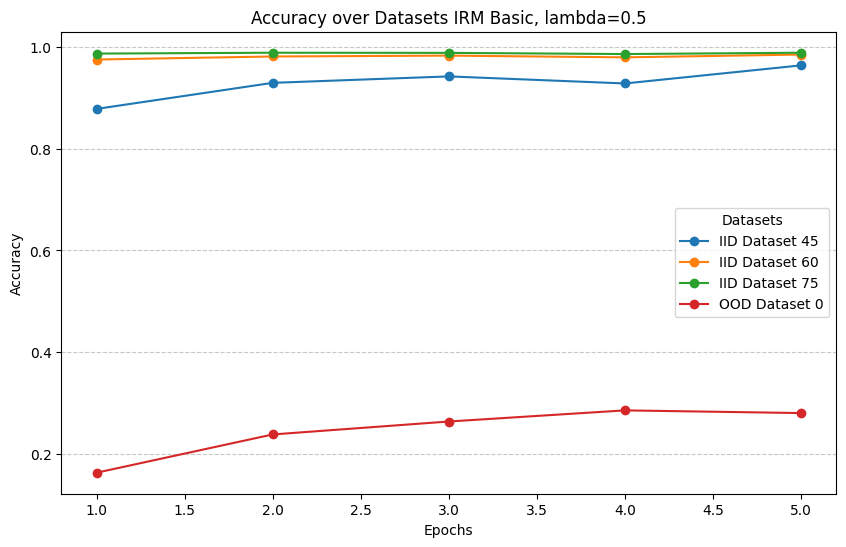

In [46]:
# print(iid_acc_basic)
# print(ood_acc_basic)
# print(len(source_loaders))
plt.figure(figsize=(10, 6))

for i in range(len(source_loaders)):
    # print (range(1,num_epochs+1))
    plt.plot(range(1, num_epochs + 1), iid_acc_basic[i,:], marker='o', label=f'IID Dataset {source_loaders_names[i]}')
for j in range(len(test_loaders)):
    plt.plot(range(1, num_epochs + 1), ood_acc_basic[j,:], marker='o', label=f'OOD Dataset {test_loader_names[j]}')

plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title(f"Accuracy over Datasets IRM Basic, lambda={lambda_penalty}")
plt.legend(title="Datasets")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()


In [47]:
for test_loader in test_loaders:
  accuracy_basic=evaluate(test_loader,feature_extractor_basic,classifier_basic)
  print(f"Test Accuracy: {accuracy_basic * 100:.2f}%")

Test Accuracy: 27.99%


IB-IRM

In [48]:
feature_extractor_ib = FeatureExtractor().to(device)
classifier_ib = Classifier(128,num_classes).to(device)
optimizer_ib = optim.Adam(list(feature_extractor_ib.parameters()) + list(classifier_ib.parameters()), lr=1e-3)
iid_acc_ib,ood_acc_ib=training_irm(classifier=classifier_ib, feature_extractor=feature_extractor_ib, source_loaders=source_loaders, source_loader_names=source_loaders_names,source_testers=source_testers,test_loaders=test_loaders,test_loader_names=test_loader_names, optimizer=optimizer_ib, device=device, num_epochs=5,lambda_penalty=lambda_penalty,gamma_var=gamma_var, w1=w1,w2=w2,w3=w3,technique='ib')

Source Dataset  45
Epoch [1/5], Batch [20/938], Loss: 2.3055
Epoch [1/5], Batch [40/938], Loss: 1.3590
Epoch [1/5], Batch [60/938], Loss: 0.8938
Epoch [1/5], Batch [80/938], Loss: 0.8273
Epoch [1/5], Batch [100/938], Loss: 0.6500
Epoch [1/5], Batch [120/938], Loss: 0.7002
Epoch [1/5], Batch [140/938], Loss: 0.5977
Epoch [1/5], Batch [160/938], Loss: 0.5885
Epoch [1/5], Batch [180/938], Loss: 0.4069
Epoch [1/5], Batch [200/938], Loss: 0.4542
Epoch [1/5], Batch [220/938], Loss: 0.4370
Epoch [1/5], Batch [240/938], Loss: 0.4031
Epoch [1/5], Batch [260/938], Loss: 0.3490
Epoch [1/5], Batch [280/938], Loss: 0.4652
Epoch [1/5], Batch [300/938], Loss: 0.3512
Epoch [1/5], Batch [320/938], Loss: 0.3697
Epoch [1/5], Batch [340/938], Loss: 0.2990
Epoch [1/5], Batch [360/938], Loss: 0.2728
Epoch [1/5], Batch [380/938], Loss: 0.3109
Epoch [1/5], Batch [400/938], Loss: 0.2403
Epoch [1/5], Batch [420/938], Loss: 0.3061
Epoch [1/5], Batch [440/938], Loss: 0.2543
Epoch [1/5], Batch [460/938], Loss: 0.2

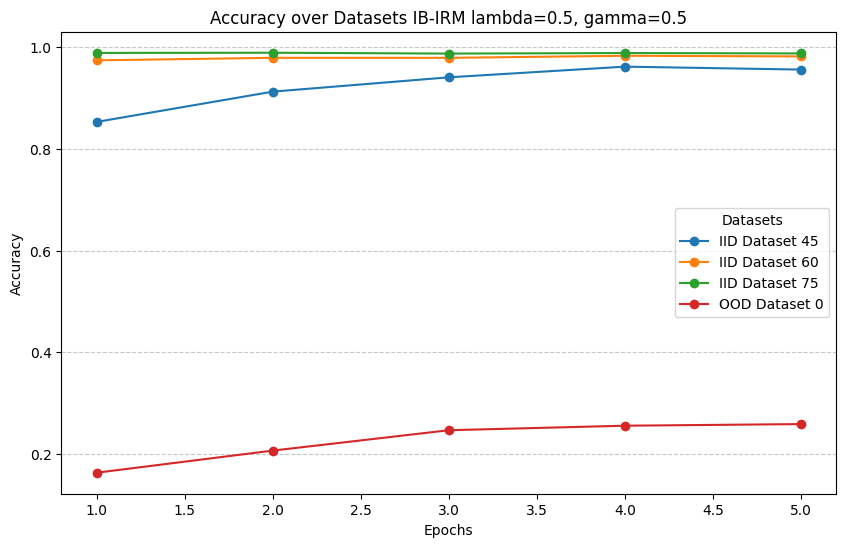

In [49]:
plt.figure(figsize=(10, 6))

for i in range(len(source_loaders)):
    plt.plot(range(1, num_epochs + 1), iid_acc_ib[i,:], marker='o', label=f'IID Dataset {source_loaders_names[i]}')
for j in range(len(test_loaders)):
    plt.plot(range(1, num_epochs + 1), ood_acc_ib[j,:], marker='o', label=f'OOD Dataset {test_loader_names[j]}')

plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title(f"Accuracy over Datasets IB-IRM lambda={lambda_penalty}, gamma={gamma_var}")
plt.legend(title="Datasets")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

In [50]:
for test_loader in test_loaders:
  accuracy_ib=evaluate(test_loader,feature_extractor_ib,classifier_ib)
  print(f"Test Accuracy: {accuracy_ib * 100:.2f}%")

Test Accuracy: 25.87%


PAIR-IRM

In [51]:
feature_extractor_pair = FeatureExtractor().to(device)
classifier_pair = Classifier(128,num_classes).to(device)
optimizer_pair = optim.Adam(list(feature_extractor_pair.parameters()) + list(classifier_pair.parameters()), lr=1e-3)
iid_acc_pair,ood_acc_pair=training_irm(classifier=classifier_pair, feature_extractor=feature_extractor_pair, source_loaders=source_loaders, source_loader_names=source_loaders_names,source_testers=source_testers,test_loaders=test_loaders,test_loader_names=test_loader_names, optimizer=optimizer_pair, device=device, num_epochs=5,lambda_penalty=lambda_penalty,gamma_var=gamma_var, w1=w1,w2=w2,w3=w3,technique='pair')

Source Dataset  45
Epoch [1/5], Batch [20/938], Loss: 4.0372
Epoch [1/5], Batch [40/938], Loss: 2.0815
Epoch [1/5], Batch [60/938], Loss: 1.2558
Epoch [1/5], Batch [80/938], Loss: 1.3332
Epoch [1/5], Batch [100/938], Loss: 1.1489
Epoch [1/5], Batch [120/938], Loss: 0.9571
Epoch [1/5], Batch [140/938], Loss: 0.8852
Epoch [1/5], Batch [160/938], Loss: 0.5842
Epoch [1/5], Batch [180/938], Loss: 0.9350
Epoch [1/5], Batch [200/938], Loss: 0.5361
Epoch [1/5], Batch [220/938], Loss: 0.6097
Epoch [1/5], Batch [240/938], Loss: 0.6010
Epoch [1/5], Batch [260/938], Loss: 0.4389
Epoch [1/5], Batch [280/938], Loss: 0.4784
Epoch [1/5], Batch [300/938], Loss: 0.5103
Epoch [1/5], Batch [320/938], Loss: 0.4677
Epoch [1/5], Batch [340/938], Loss: 0.3701
Epoch [1/5], Batch [360/938], Loss: 0.4592
Epoch [1/5], Batch [380/938], Loss: 0.4695
Epoch [1/5], Batch [400/938], Loss: 0.3088
Epoch [1/5], Batch [420/938], Loss: 0.4665
Epoch [1/5], Batch [440/938], Loss: 0.4106
Epoch [1/5], Batch [460/938], Loss: 0.4

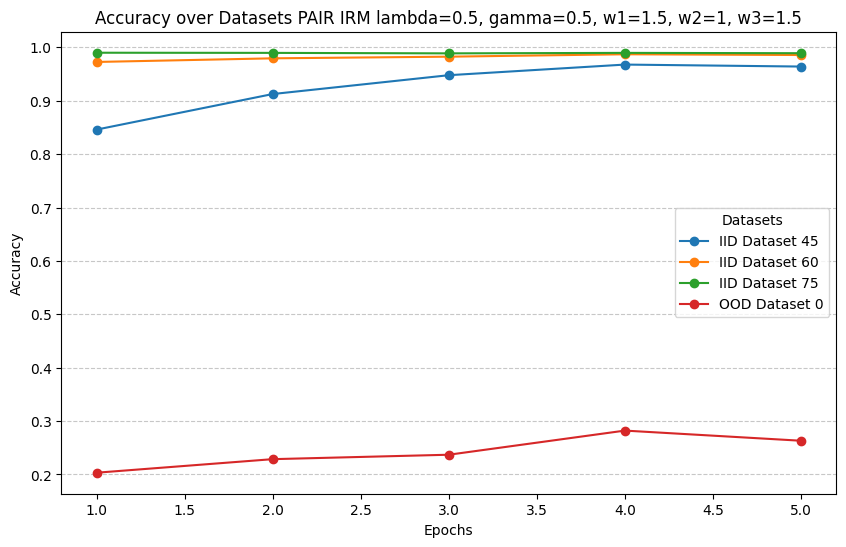

In [52]:
plt.figure(figsize=(10, 6))

for i in range(len(source_loaders)):
    plt.plot(range(1, num_epochs + 1), iid_acc_pair[i,:], marker='o', label=f'IID Dataset {source_loaders_names[i]}')
for j in range(len(test_loaders)):
    plt.plot(range(1, num_epochs + 1), ood_acc_pair[j,:], marker='o', label=f'OOD Dataset {test_loader_names[j]}')

plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title(f"Accuracy over Datasets PAIR IRM lambda={lambda_penalty}, gamma={gamma_var}, w1={w1}, w2={w2}, w3={w3}")
plt.legend(title="Datasets")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

In [53]:
for test_loader in test_loaders:
  accuracy_pair=evaluate(test_loader,feature_extractor_pair,classifier_pair)
  print(f"Test Accuracy: {accuracy_pair * 100:.2f}%")

Test Accuracy: 26.32%
